<a href="https://colab.research.google.com/github/yohei0408/kikagaku/blob/main/20241007_signate_%E5%82%B5%E5%8B%99%E4%B8%8D%E5%B1%A5%E8%A1%8C%E5%95%8F%E9%A1%8C_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torchmetrics==0.11.4 pytorch_lightning==2.0.2
# インストールした torchmetrics のバージョンを確認
import torchmetrics
from torchmetrics.functional import accuracy

torchmetrics.__version__
# インストールした PyTorch Lightning のバージョンを確認
import pytorch_lightning as pl

pl.__version__
# エラーが出た際は、一度ランタイムを再起動してください
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 13.3 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv('/content/train.csv')
df = df.drop(['id'], axis=1)
# loan_status を数値に変換
df['loan_status'] = df['loan_status'].map({'ChargedOff': 1, 'FullyPaid': 0})
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242150 entries, 0 to 242149
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loan_amnt          242150 non-null  float64
 1   term               242150 non-null  object 
 2   interest_rate      242150 non-null  float64
 3   grade              242150 non-null  object 
 4   employment_length  242150 non-null  object 
 5   purpose            242150 non-null  object 
 6   credit_score       242150 non-null  float64
 7   application_type   242150 non-null  object 
 8   loan_status        242150 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 16.6+ MB


In [ ]:


# サンプルデータフレーム
# df = pd.DataFrame(...)  # 実際のデータフレームを使用

# loan_statusが1のサンプル数と0のサンプル数を分ける 1が少ない
df_loan_status_1 = df[df['loan_status'] == 1]
df_loan_status_0 = df[df['loan_status'] == 0]

# どちらか少ないほうのサンプル数を取得
min_samples = min(len(df_loan_status_1), len(df_loan_status_0))

min_samples = min_samples * 1

# 多い方のクラスを少数クラスと同じ数だけランダムにサンプリング
df_loan_status_1_downsampled = df_loan_status_1
df_loan_status_0_downsampled = df_loan_status_0.sample(n=min_samples, random_state=0)

# ダウンサンプリング後のデータを結合
df = pd.concat([df_loan_status_1_downsampled, df_loan_status_0_downsampled])

# データをシャッフル（任意）
df = df.sample(frac=1, random_state=0).reset_index(drop=True)

# 結果を確認
print(df['loan_status'].value_counts())

loan_status
1    42356
0    42356
Name: count, dtype: int64


In [ ]:

# 各 grade ごとの Charged Off の割合を計算
charged_off_rates1 = df.groupby('grade')['loan_status'].value_counts(normalize=True).unstack().fillna(0)
charged_off_rates1 = charged_off_rates1[1]  # Charged Off のみを抽出

# 各 purpose ごとの Charged Off の割合を計算
charged_off_rates2 = df.groupby('purpose')['loan_status'].value_counts(normalize=True).unstack().fillna(0)
charged_off_rates2 = charged_off_rates2[1]  # Charged Off のみを抽出

# 各 purpose ごとの Charged Off の割合を計算
charged_off_rates3 = df.groupby('application_type')['loan_status'].value_counts(normalize=True).unstack().fillna(0)
charged_off_rates3 = charged_off_rates3[1]  # Charged Off のみを抽出

# 各 term ごとの Charged Off の割合を計算
charged_off_rates4 = df.groupby('term')['loan_status'].value_counts(normalize=True).unstack().fillna(0)
charged_off_rates4 = charged_off_rates4[1]  # Charged Off のみを抽出

# 各 employment_length ごとの Charged Off の割合を計算
charged_off_rates5 = df.groupby('employment_length')['loan_status'].value_counts(normalize=True).unstack().fillna(0)
charged_off_rates5 = charged_off_rates5[1]  # Charged Off のみを抽出



df_2 = df.copy()

# dfのgrade列をcharged_off_ratesに基づいて数値に変換
df_2['grade'] = df_2['grade'].map(charged_off_rates1)
# dfのgrade列をcharged_off_ratesに基づいて数値に変換
df_2['purpose'] = df_2['purpose'].map(charged_off_rates2)
# dfのgrade列をcharged_off_ratesに基づいて数値に変換
df_2['application_type'] = df_2['application_type'].map(charged_off_rates3)
df_2['term'] = df_2['term'].map(charged_off_rates4)
df_2['employment_length'] = df_2['employment_length'].map(charged_off_rates5)

df_3 = df_2.copy()
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84712 entries, 0 to 84711
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loan_amnt          84712 non-null  float64
 1   term               84712 non-null  float64
 2   interest_rate      84712 non-null  float64
 3   grade              84712 non-null  float64
 4   employment_length  84712 non-null  float64
 5   purpose            84712 non-null  float64
 6   credit_score       84712 non-null  float64
 7   application_type   84712 non-null  float64
 8   loan_status        84712 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 5.8 MB


In [181]:
x = df_3.drop(['loan_status'], axis=1)
t = df_3[['loan_status']]


# PyTorch で学習に使用できる形式へ変換
x = torch.tensor(x.values, dtype=torch.float32)
t = torch.tensor(t.values, dtype=torch.int64)

In [182]:
count_of_ones = (t == 1).sum().item()
print(f"Number of 1s in t: {count_of_ones}")


Number of 1s in t: 42356


In [183]:
# 入力値と目標値をまとめる
dataset = torch.utils.data.TensorDataset(x, t)
# 各データセットのサンプルサイズを決定
# train : val: test = 60%　: 20% : 20%
n_train = int(len(dataset) * 0.6)
n_val = int(len(dataset) * 0.2)
n_test = len(dataset) - n_train - n_val
# ランダムに分割を行うため、シードを固定して再現性を確保
pl.seed_everything(0)

# データセットの分割
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])
# ランダムに分割を行うため、シードを固定して再現性を確保
pl.seed_everything(0)

# バッチサイズの定義
batch_size = 50

# Data Loader を用意
# shuffle はデフォルトで False のため、訓練データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

INFO:lightning_fabric.utilities.seed:Global seed set to 0
INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [184]:
class Net(pl.LightningModule):

    def __init__(self):
        super().__init__()

        self.bn = nn.BatchNorm1d(8)
        self.fc1 = nn.Linear(8, 5)
        self.fc2 = nn.Linear(5, 2)

    def forward(self, x):
        h = self.bn(x)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fc2(h)
        return h

    def training_step(self, batch, batch_idx):
        x, t = batch

        # ターゲット t が1次元の整数ラベルであることを確認
        if t.dim() > 1:
            t = t.squeeze()  # もしターゲットが多次元なら1次元に変換

        y = self(x)
        predictions = torch.argmax(y, dim=1)

        # 損失を計算
        loss = F.cross_entropy(y, t)  # t は1次元の整数ラベル
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)

        # 精度を計算 (2値分類)
        self.log('train_acc', accuracy(predictions, t, task='binary'), on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t = batch

        # ターゲット t が1次元の整数ラベルであることを確認
        if t.dim() > 1:
            t = t.squeeze()

        y = self(x)
        predictions = torch.argmax(y, dim=1)

        # 損失を計算
        loss = F.cross_entropy(y, t)
        self.log('val_loss', loss, on_step=False, on_epoch=True)

        # 精度を計算 (2値分類)
        self.log('val_acc', accuracy(predictions, t, task='binary'), on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, t = batch

        # ターゲット t が1次元の整数ラベルであることを確認
        if t.dim() > 1:
            t = t.squeeze()

        y = self(x)
        predictions = torch.argmax(y, dim=1)

        # 損失を計算
        loss = F.cross_entropy(y, t)
        self.log('test_loss', loss, on_step=False, on_epoch=True)

        # 精度を計算 (2値分類)
        self.log('test_acc', accuracy(predictions, t, task='binary'), on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        #optimizer = torch.optim.SGD(self.parameters(), lr=0.01) #0.3732823
        #optimizer = torch.optim.AdamW(self.parameters(), lr=0.001, weight_decay=0.01) #0.3754166
        #optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-5)
        #optimizer = torch.optim.Adadelta(self.parameters(), lr=1.0, rho=0.9) # 0.3786402
        #optimizer = torch.optim.NAdam(self.parameters(), lr=0.001)
        optimizer = torch.optim.Adagrad(self.parameters(), lr=0.01)




        return optimizer


In [185]:
# GPU を含めた乱数のシードを固定
pl.seed_everything(0)

# 学習の実行
net = Net()
logger = CSVLogger(save_dir='logs', name='my_exp')
trainer = pl.Trainer(max_epochs=10, accelerator="cpu", deterministic=False, logger=logger)
trainer.fit(net, train_loader, val_loader)
# テストデータで検証
results = trainer.test(dataloaders=test_loader)

INFO:lightning_fabric.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory logs/my_exp/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type        | Params
-------------------------------------
0 | bn   | BatchNorm1d | 16    
1 | fc1  | Linear      | 45    
2 | fc2  | Linear      | 12    
-------------------------------------
73        Trainable params
0         Non-trainable params
73        Total params
0.000     Total estimated m

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/my_exp/version_0/checkpoints/epoch=9-step=10160-v6.ckpt
/usr/local/lib/python3.10/dist-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.6448680758476257     │
│         test_loss         │    0.6181582808494568     │
└───────────────────────────┴───────────────────────────┘

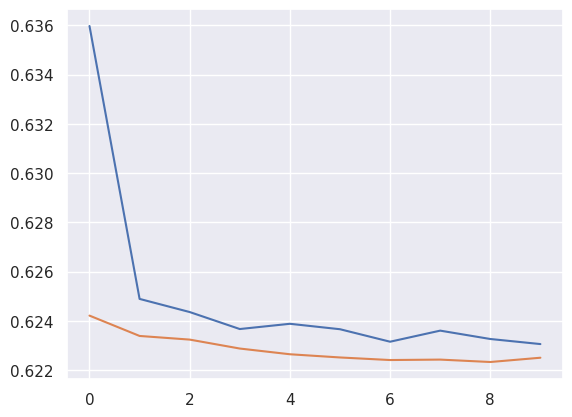

In [186]:
log = pd.read_csv('logs/my_exp/version_0/metrics.csv')
# loss
log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot();
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot();

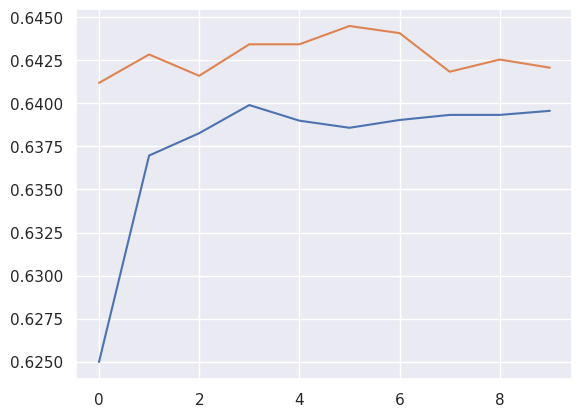

In [187]:
# accuracy
log[['train_acc_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_acc_epoch'].plot();
log[['val_acc', 'epoch']].dropna(how='any', axis=0).reset_index()['val_acc'].plot();

In [188]:
# 学習済みモデルを保存
torch.save(net.state_dict(), 'loan_status(Adagrad).pt')

In [189]:
test_df = pd.read_csv('/content/test.csv')
test_df2 = test_df.drop(['id'], axis=1)

# dfのgrade列をcharged_off_ratesに基づいて数値に変換
test_df2['grade'] = test_df2['grade'].map(charged_off_rates1)
# dfのgrade列をcharged_off_ratesに基づいて数値に変換
test_df2['purpose'] = test_df2['purpose'].map(charged_off_rates2)
# dfのgrade列をcharged_off_ratesに基づいて数値に変換
test_df2['application_type'] = test_df2['application_type'].map(charged_off_rates3)
test_df2['term'] = test_df2['term'].map(charged_off_rates4)
test_df2['employment_length'] = test_df2['employment_length'].map(charged_off_rates5)
test_df2.head()

,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type
0,1161.830205,0.438864,13.105362,0.461142,0.517274,0.437081,682.016083,0.500273
1,2257.465815,0.659895,14.196200,0.638202,0.517274,0.519830,668.240313,0.500273
2,2182.137002,0.438864,8.307772,0.152315,0.517274,0.437081,703.277694,0.500273
3,520.284912,0.438864,6.956504,0.222300,0.440863,0.519830,731.138779,0.500273
4,2303.349549,0.438864,11.658497,0.344461,0.453899,0.519830,698.368991,0.500273


In [190]:
x = torch.tensor(test_df2.values, dtype=torch.float32)
# 予測


In [191]:
# モデルのインスタンス化と重みのロード
net = Net().eval()
net.load_state_dict(torch.load('loan_status(Adagrad).pt'))

<ipython-input-191-e8cb442affcd>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('loan_status(Adagrad).pt'))


<All keys matched successfully>

In [192]:
# 予測
y = net(x).view(-1).cpu().detach().numpy() # NumPy 型に変換
y

array([ 0.18308774,  0.00911509, -0.32429284, ..., -0.08447608,
        1.4969461 , -0.3114848 ], dtype=float32)

In [193]:
with torch.no_grad():
    y = net(x).view(-1)
y

tensor([ 0.1831,  0.0091, -0.3243,  ..., -0.0845,  1.4969, -0.3115])

In [194]:
y = torch.argmax(net(x), dim=1)
y

tensor([0, 1, 0,  ..., 0, 0, 0])

In [195]:
zero_count = (y == 0).sum()

# 結果を表示
print(f"y列の0の数: {zero_count}")
result_df = pd.DataFrame({
    'id': test_df['id'],  # 1列目: test_dfのid列
    'prediction': y       # 2列目: 予測値y
})
result_df = result_df.astype(int)
result_df.head()

y列の0の数: 13853


,id,prediction
0,242150,0
1,242151,1
2,242152,0
3,242153,0
4,242154,0


In [196]:
# 列名なしでCSVに保存
result_df.to_csv('submit_dl_Adagrad.csv', index=False, header=False)